In [1]:

#Sandesh
import os
import numpy as np
from PIL import Image

def LoadSceneAndLabel(dirnameScene, dirnameLabel, numImages):
    count = 0
    sceneX = []
    sceneY = []
    for sceneName in os.listdir(dirnameScene):
        scene = Image.open(os.path.join(dirnameScene, sceneName))
        sceneLabel = Image.open(os.path.join(dirnameLabel, sceneName[:-4]+"_drivable_color.png"))
        #scene.show()
        #sceneLabel.show()
        #print(scene.size)
        #print(sceneLabel.size)
        sceneX.append(scene)
        sceneY.append(sceneLabel)
        count += 1
        if count >= numImages:
          break
    return sceneX, sceneY

dataX, dataY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/train", dirnameLabel="bdd100k/drivable_maps/color_labels/train", numImages=500)
valX, valY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/val", dirnameLabel="bdd100k/drivable_maps/color_labels/val", numImages=20)

dataX[0].size


(1280, 720)

In [2]:
import math
def compress(x, y, rate=0.5):
    print((x[0].size))
    xSize = math.floor(((x[0].size)[0])*rate)
    ySize = math.floor(((y[0].size)[1])*rate)
#     print(xSize)
#     print(ySize)
    sceneX = [img.resize([xSize, ySize]) for img in x]  
    sceneY = [img.resize([xSize, ySize]) for img in y]  
    #sceneX[0].show()
    #sceneY[0].show()
    return sceneX, sceneY

# #print(SceneLabelPair[0][0].size)
dataX, dataY = compress(dataX, dataY, rate=0.1)
# print(SceneLabelPair[0][0].size)
valX, valY = compress(valX, valY, rate=0.1)

print(dataX[0].size)

(1280, 720)
(1280, 720)
(128, 72)


## maybe flatten y?

In [3]:
# 
#convert non zero label to be the same number so it's not different based on different lane categorization

def convert_to_array(x, y):
    sceneX = []
    sceneY = []
    count = 0
    for img in x:
        img = img.convert('LA')  # convert to grayscale
        img = np.squeeze(np.array(img)[:,:,0])
        #divide by 255.0
        img = np.divide(img, 255.0)
        sceneX.append(img)
    for img in y:
        img = img.convert('LA')  # convert to grayscale
        if count == 0:
            img.show()
        count = 1
        img = np.squeeze(np.array(img)[:,:,0])
        img = np.where(img > 0, 1, 0)
        sceneY.append(img)
#     img = np.squeeze(np.array(img)[:, :, 0]) #squeeze to remove the unnecessary dimension after conversion to grayscale
#     label_img = np.squeeze(np.array(label_img)[:, :, 0])
    return np.array(sceneX), np.array(sceneY)

dataX, dataY = convert_to_array(dataX, dataY)
valX, valY = convert_to_array(valX, valY)

In [4]:
print(len(dataX))
print(len(dataY))


dataX.shape

500
500


(500, 72, 128)

### Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

split = 2/7.0
print(split)

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=split) 


0.2857142857142857


In [6]:
train_num = trainX.shape[0]
test_num = testX.shape[0]
x_dim = trainX.shape[2]
y_dim = trainX.shape[1]
val_num = valX.shape[0]



# Pytorch CNN Model

Module is the baseclass for all NN module:
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

### Conv2D -> 
Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
https://cs231n.github.io/convolutional-networks/
out_channels = number of kernels (filters) used, so dim in the 3rd dim


### BatchNorm2d ->
BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Batch normalization normalizes the activations of the network between layers in batches so that the batches have a mean of 0 and a variance of 1.
param = num of channels

### nn.Linear ->
Linear(in_features, out_features, bias=True)



### Convert to PyTorch types


In [7]:
import torch
# train

trainX = trainX.reshape(train_num, 1, y_dim, x_dim).astype(float)
print(trainX[0])
print(trainX.shape)
trainX  = torch.from_numpy(trainX).type(torch.FloatTensor)

# trainY = trainY.reshape(train_num, 1, x_dim, y_dim).astype(float)
# trainY  = torch.from_numpy(trainY)
# print(trainY.shape)

trainY = trainY.reshape(train_num, x_dim * y_dim).astype(float)
#trainY  = torch.from_numpy(trainY).type(torch.LongTensor)
trainY  = torch.from_numpy(trainY).type(torch.FloatTensor)
print(trainY.shape)



# val
valX = valX.reshape(val_num, 1, y_dim, x_dim).astype(float)
print(valX[0])
print(valX.shape)
valX  = torch.from_numpy(valX).type(torch.FloatTensor)

# valY = valY.reshape(val_num, 1, x_dim, y_dim).astype(float)
# valY  = torch.from_numpy(valY)


valY = valY.reshape(val_num, x_dim * y_dim).astype(float)
#valY  = torch.from_numpy(valY).type(torch.LongTensor)
valY  = torch.from_numpy(valY).type(torch.FloatTensor)
# //TODO Test




[[[0.94901961 0.95294118 0.95294118 ... 0.47843137 0.50588235 0.49019608]
  [0.95294118 0.94901961 0.95294118 ... 0.47058824 0.45882353 0.49411765]
  [0.91764706 0.96078431 0.94901961 ... 0.51764706 0.26666667 0.2745098 ]
  ...
  [0.1254902  0.10588235 0.08627451 ... 0.10588235 0.10196078 0.10196078]
  [0.03137255 0.02745098 0.02745098 ... 0.23529412 0.22352941 0.22745098]
  [0.0745098  0.08235294 0.09803922 ... 0.46666667 0.35686275 0.29411765]]]
(357, 1, 72, 128)
torch.Size([357, 9216])
[[[0.42745098 0.42745098 0.2745098  ... 0.03137255 0.02745098 0.02745098]
  [0.41960784 0.34901961 0.28235294 ... 0.03137255 0.02745098 0.02745098]
  [0.40784314 0.38823529 0.18823529 ... 0.03529412 0.03137255 0.02745098]
  ...
  [0.10588235 0.10196078 0.09019608 ... 0.36862745 0.36470588 0.36078431]
  [0.02352941 0.02352941 0.02352941 ... 0.35686275 0.35294118 0.35294118]
  [0.02745098 0.02745098 0.02745098 ... 0.34901961 0.34901961 0.34509804]]]
(20, 1, 72, 128)


In [8]:
trainX.shape, trainY.shape

(torch.Size([357, 1, 72, 128]), torch.Size([357, 9216]))

In [9]:
# import torch

# torch.cuda.current_device()
# torch.cuda.is_available()

In [10]:
from torch.nn import Conv2d
from torch.nn import Linear, ReLU, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten

# calculating the size of output from convolution layers
dat = trainX[:1].type(torch.FloatTensor)
print(dat.size())
#x = dat.to(device=device, dtype=torch.float)
conv = Conv2d(1, 2, kernel_size=3, stride=1, padding=1)
out = conv(dat)
mp = MaxPool2d(kernel_size=2, stride=2)
out = mp(out)
conv2 = Conv2d(2, 3, kernel_size=5, stride=1, padding=1)
out = conv2(out)
bN = BatchNorm2d(3)
out = bN(out)
mp2 = MaxPool2d(kernel_size=3, stride=2)
out = mp2(out)
out.size()


torch.Size([1, 1, 72, 128])


torch.Size([1, 3, 16, 30])

In [30]:
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam, SGD
import torch.nn as nn

class CNN(Module):
    def __init__(self):
        super(CNN,self).__init__() #base class for all neural network modules
        out_chan_1 = 2
        out_chan_2 = 3
        k_s_1 = 3
        k_s_2 = 5
        k_s_1_mp = 2 #mp = max pool
        k_s_2_mp = 2
        
        num_neurons_1 = 10
        
        output_size = 9216 #depending on num of pixels
        
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
            BatchNorm2d(out_chan_1), #just specify the num of output channels
            ReLU(inplace=True),
            MaxPool2d(kernel_size=k_s_1_mp, stride=2),
            # Defining another 2D convolution layer
            Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=k_s_2_mp, stride=2)
        )
        
        self.linear_layers = Sequential(
            Linear(out_chan_2 * 31 * 17, num_neurons_1),
            Softmax(dim=1),
            #ReLU(inplace=True),
            Linear(num_neurons_1,output_size),
            Sigmoid() # map from 0 to 1
            #Softmax(dim=1)
            #Sign()
            #ReLU(inplace=True)
            
        )
        
    # Defining the forward pass    
    def forward(self, x):
        
        x = self.cnn_layers(x)
        print(x.size())
        #x=x.long()
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #x = x.float()
        return x
    

# defining the model
model = CNN()
# defining the optimizer
optimizer =  torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.0005)

#optimizer = Adam(model.parameters(), lr=0.05)

# defining the loss function
criterion = MSELoss()
#criterion = CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()


# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# print(model)

# trainX = trainX[:2].cuda()

# output = model(Variable(trainX))
# output



def train(epoch, train_x, train_y, val_x, val_y):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    print(output_train.shape)
    print(y_train.shape)
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [32]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch, trainX, trainY, valX, valY)

torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
Epoch :  1 	 loss : tensor(0.2525, grad_fn=<MseLossBackward>)
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
Epoch :  3 	 loss : tensor(0.2525, grad_fn=<MseLossBackward>)
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
Epoch :  5 	 loss : tensor(0.2525, grad_fn=<MseLossBackward>)
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
torch.Size([357, 3, 17, 31])
torch.Size([20, 3, 17, 31])
torch.Size([357, 9216])
torch.Size([357, 9216])
Epoch :  7 	 loss : tensor(0.2525, grad_fn=<MseLossBackward>)
torch.Size([357, 

In [13]:
# import matplotlib.pyplot as plt 
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.show()

#discussion with Chau

should label data be 0 and 1 per pixel rather than whatever it currently is?
should we normalize all the images to be closer to 1 rather than such large numbers?
should just discussion on loss function -> i think mseloss would be best for pixel by pixel comparison?
should final output be filtered using something other than nerual network?


In [33]:
testSingle = valX[0:1]
#testSingle = testSingle.cuda()
y_pred = model(testSingle)


out = y_pred.cpu().detach().numpy()

print(valY[0].numpy().shape)
print(out)

final = np.where(out > np.mean(out), 1, 0)

final = np.reshape(final, (72, 128))*255

actual = ((np.reshape(valY[0].numpy(), (72, 128)))*255)

print(actual)

print(final)

torch.Size([1, 3, 17, 31])
(9216,)
[[0.51428044 0.43378332 0.57502514 ... 0.4416776  0.4225259  0.49711508]]
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 255. 255.]]
[[255   0 255 ... 255   0 255]
 [  0   0   0 ... 255   0 255]
 [  0 255   0 ... 255   0 255]
 ...
 [255 255   0 ... 255 255   0]
 [255   0 255 ... 255   0   0]
 [255 255 255 ...   0   0   0]]


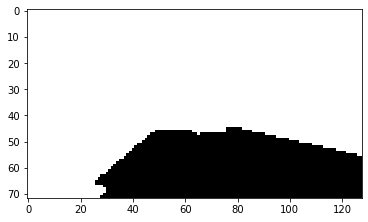

In [34]:
import matplotlib.pyplot as plt
plt.imshow(actual, cmap="Greys")

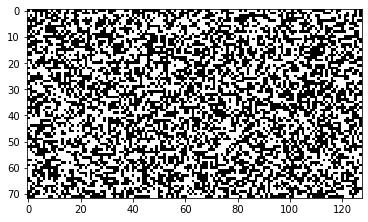

In [35]:
plt.imshow(final, cmap="Greys")